## Installs

In [ ]:
#Install packages to apply SVD and Bayesian Factorization Machine
!pip install surprise

!pip install myfm

## Imports

In [1]:
# To store the data
import pandas as pd

# To do linear algebra
import numpy as np

# To apply SVD
import surprise

# To apply Factorization Machines
import myfm
from myfm import RelationBlock
from myfm.utils.encoders import(DataFrameEncoder,MultipleValuesToSparseEncoder,CategoryValueToSparseEncoder)

# To do train-test split for evaluation
from sklearn.model_selection import train_test_split

## Download Data

In [ ]:
!pip install kaggle

!mkdir ~/.kaggle

import json

kaggle_username = "yuvalnis" #@param {type:"string"}
kaggle_api_key = "1800d5a286834f0416c338c7bd7f6dee" #@param {type:"string"}

assert len(kaggle_username) > 0 and len(kaggle_api_key) > 0

api_token = {"username": kaggle_username,"key": kaggle_api_key}

with open('kaggle.json', 'w') as file:
    json.dump(api_token, file)

!mv kaggle.json ~/.kaggle/kaggle.json

!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c cil-collaborative-filtering-2022

!unzip -n cil-collaborative-filtering-2022.zip

## Load Data

In [2]:
#Function to Extract users, movies and ratings from raw data
def extract_users_items_predictions(data_pd):
    users, movies = \
        [np.squeeze(arr) for arr in np.split(data_pd.Id.str.extract('r(\d+)_c(\d+)').values.astype(int) - 1, 2, axis=-1)]
    predictions = data_pd.Prediction.values
    return users, movies, predictions

#Load raw data
data_pd = pd.read_csv('data_train.csv')

#Do Train-Test Split
train, val = train_test_split(data_pd, test_size=0.1,random_state=42)

#Extract users, movies and ratings from raw data
total_users, total_movies, total_pred = extract_users_items_predictions(data_pd)
train_users, train_movies, train_pred = extract_users_items_predictions(train)
val_users, val_movies, val_pred = extract_users_items_predictions(val)

#Store total data
ratings_dict_total = {'userID': total_users,'movieID': total_movies,'rating': total_pred}
df_total = pd.DataFrame(ratings_dict_total)

#Store train data
ratings_dict_train = {'userID': train_users,'movieID': train_movies,'rating': train_pred}
df_train = pd.DataFrame(ratings_dict_train)

#Store validation data
ratings_dict_test = {'userID': val_users,'movieID': val_movies,'rating': val_pred}
df_test = pd.DataFrame(ratings_dict_test)

## Apply SVD 

In [3]:
def surprise_svd(df):
    
    # Transform Data in Desired Format
    reader = surprise.Reader(rating_scale=(0,5.5))
    surprise_data = surprise.Dataset.load_from_df(df[['userID', 'movieID', 'rating']], reader=reader)
    trainset = surprise_data.build_full_trainset()
    
    #Apply SVD
    algo = surprise.SVD(n_factors=3, n_epochs=50,random_state=1234, biased=False)
    algo.fit(trainset)
    
    #Get User/Movie Factors
    U = algo.pu
    Q = algo.qi
    return U,Q

U,Q = surprise_svd(df_train)

## Get cosine and implicit user/movie Features
- code is based on https://github.com/tohtsky/myFM/blob/main/examples/ml-100k-extended.ipynb

In [4]:
#Utility function to convert list to str
def string_agg(int_list) -> str:
    return ','.join([str(y) for y in int_list])

#Store user vectors
user_vec = []
for i in range(10000):
    user_vec.append(dict(enumerate(np.array(U[i]).flatten(), 1)))

#Store movie vectors
movie_vec = []
for i in range(1000):
    movie_vec.append(dict(enumerate(np.array(Q[i]).flatten(), 1)))
    

#Store features in a df
user_f = pd.DataFrame(np.arange(10000),columns=['userID'])
user_f['user_implicit_features'] = df_train.groupby('userID').movieID.agg(string_agg).reindex(user_f.index).fillna('')
user_f['user_vec'] = user_vec



movie_f = pd.DataFrame(np.arange(1000),columns=['movieID'])
movie_f['movie_implicit_features'] = df_train.groupby('movieID').userID.agg(string_agg).reindex(movie_f.index).fillna('')
movie_f['movie_vec'] = movie_vec

In [5]:
# Modify Existing MultipleValuesToSparseEncoder to Store different vector values instead on simple encoding
from typing import Iterable

import scipy.sparse as sps
from typing_extensions import Literal

class ValuesToSparseEncoder(CategoryValueToSparseEncoder[str]):
    """The class to N-hot encode a List of items into a sparse matrix representation."""

    def __init__(
        self,
        items: Iterable[str],
        min_freq: int = 1,
        sep: str = ",",
        normalize: bool = True,
        handle_unknown: Literal["create", "ignore", "raise"] = "create",
    ):
        items_flatten = [
            y for x in items for y in set(self.string_agg(list(x.keys())).split(sep)) if y
        ]  # ignore empty string.
        self.sep = sep
        self.normalize = normalize
        super().__init__(
            items_flatten, min_freq=min_freq, handle_unknown=handle_unknown
        )

    def to_sparse(self, items: Iterable[str]) -> sps.csr_matrix:
        indptr = [0]
        indices = []
        data = []
        n_row = 0
        cursor = 0
        for row in items:
            n_row += 1
            items = self.string_agg(list(row.keys())).split(self.sep)
            indices_local = [index for index in [self._get_index(v) for v in items if v] if index is not None]
            if not indices_local:
                indptr.append(cursor)
                continue
            n = len(indices_local)
            indices.extend(indices_local)
            
            #use vector values
            values = list(row.values())
            data.extend(values)
            cursor += n
            indptr.append(cursor)
        return sps.csr_matrix(
            (data, indices, indptr),
            shape=(n_row, len(self)),
        )
    def string_agg(self,int_list) -> str:
        return ','.join([str(y) for y in int_list])

# Transform Data in myFM Format

In [6]:
#Create User Encoder
user_encoder = DataFrameEncoder().add_column(
    'userID', CategoryValueToSparseEncoder(user_f.userID)
    )

user_encoder.add_column(
        'user_implicit_features',
        MultipleValuesToSparseEncoder(user_f.user_implicit_features, normalize=True)
    )

user_encoder.add_column(
        'user_vec',
        ValuesToSparseEncoder(user_f.user_vec)
    )

#Create Movie Encoder
movie_encoder = DataFrameEncoder().add_column(
    'movieID', CategoryValueToSparseEncoder(movie_f.movieID)
    )
movie_encoder.add_column(
        'movie_implicit_features',
        MultipleValuesToSparseEncoder(movie_f.movie_implicit_features, normalize=True)
    )
movie_encoder.add_column(
        'movie_vec',
        ValuesToSparseEncoder(movie_f.movie_vec)
    )


def augment_user_id(user_ids):
    return user_encoder.encode_df(
        user_f.reindex(user_ids).reset_index()
    )

def augment_movie_id(movie_ids):
    return movie_encoder.encode_df(
        movie_f.reindex(movie_ids).reset_index()
    )


#Create Train/Test Blocks
train_blocks = []
test_blocks = []
for source, target in [(df_train, train_blocks),(df_test, test_blocks)]:
    unique_users, user_map = np.unique(source.userID, return_inverse=True)
    target.append(
        RelationBlock(user_map, augment_user_id(unique_users))
    )
    unique_movies, movie_map = np.unique(source.movieID, return_inverse=True)
    target.append(
        RelationBlock(movie_map, augment_movie_id(unique_movies))
    )

## Evaluation and Parameter Tuning

In [7]:
# Return root mean square error metric
def RMSE(x: np.ndarray, y: np.ndarray) -> float:
    return np.sqrt(np.average((x - y) ** 2))

# Function to do parameter tuning
def validation(user_encoder,movie_encoder,df_train,train_blocks,test_blocks,val_predictions):
    group_shapes = user_encoder.encoder_shapes + movie_encoder.encoder_shapes

    rank = [10,12,14,16]
    n_iter = [100,200,300,400,500]
    n_samples = [95,195,295,395,495]

    best_rmse = 1
    best_r = 0
    best_n = 0
    best_s = 0

    for r in rank:
        for i in range(len(n_iter)):
            fm_probit = myfm.MyFMOrderedProbit(rank=r, random_seed=1234)
            fm_probit.fit(None, df_train.rating.values - 1, X_rel=train_blocks,
                          group_shapes=group_shapes,n_iter=n_iter[i], n_kept_samples=n_samples[i])
            test_prediction_ordered_prob = fm_probit.predict_proba(None, test_blocks)
            test_prediction_ordered_mean = 1 + test_prediction_ordered_prob.dot(np.arange(5)) # class 0 => rating 1 shift
            rmse = RMSE(val_predictions,test_prediction_ordered_mean)
            if rmse < best_rmse:
                best_rmse = rmse
                best_r = r
                best_n = n_iter[i]
                best_s = n_samples[i]
                print(best_rmse)
                
    return best_rmse,best_r,best_n,best_s

best_rmse,best_r,best_n,best_s = validation(user_encoder,movie_encoder,df_train,train_blocks,test_blocks,val_pred)

w0 = -0.12, cutpoint = ['-2.252', '-1.509', '-0.542', '0.334'] : 100%|█| 100/100


0.9716133408375609


w0 = -0.11, cutpoint = ['-2.265', '-1.525', '-0.556', '0.321'] : 100%|█| 200/200


0.9706007622635014


w0 = -0.15, cutpoint = ['-2.283', '-1.543', '-0.572', '0.305'] : 100%|█| 300/300


0.9702002573744777


w0 = -0.14, cutpoint = ['-2.283', '-1.540', '-0.570', '0.304'] : 100%|█| 400/400


0.9699700559012089


w0 = -0.13, cutpoint = ['-2.260', '-1.516', '-0.547', '0.330'] : 100%|█| 500/500


0.9698330869851077


w0 = 0.14, cutpoint = ['-2.162', '-1.421', '-0.444', '0.435'] : 100%|█| 100/100 
w0 = 0.14, cutpoint = ['-2.126', '-1.376', '-0.397', '0.488'] : 100%|█| 200/200 
w0 = 0.12, cutpoint = ['-2.124', '-1.375', '-0.397', '0.485'] : 100%|█| 300/300 


0.9694692027421182


w0 = 0.10, cutpoint = ['-2.115', '-1.369', '-0.394', '0.488'] : 100%|█| 400/400 


0.9691596917232131


w0 = 0.09, cutpoint = ['-2.126', '-1.381', '-0.407', '0.473'] : 100%|█| 500/500 


0.969049848280866


w0 = 0.09, cutpoint = ['-2.345', '-1.598', '-0.618', '0.267'] : 100%|█| 100/100 
w0 = 0.08, cutpoint = ['-2.315', '-1.561', '-0.580', '0.307'] : 100%|█| 200/200 
w0 = 0.07, cutpoint = ['-2.279', '-1.528', '-0.547', '0.341'] : 100%|█| 300/300 
w0 = 0.07, cutpoint = ['-2.284', '-1.536', '-0.556', '0.331'] : 100%|█| 400/400 


0.9689563788004035


w0 = 0.06, cutpoint = ['-2.300', '-1.547', '-0.569', '0.319'] : 100%|█| 500/500 


0.9688279922971721


w0 = -0.02, cutpoint = ['-1.980', '-1.228', '-0.243', '0.646'] : 100%|█| 100/100
w0 = -0.01, cutpoint = ['-1.960', '-1.212', '-0.225', '0.667'] : 100%|█| 200/200
w0 = -0.01, cutpoint = ['-1.960', '-1.205', '-0.220', '0.669'] : 100%|█| 300/300
w0 = 0.00, cutpoint = ['-1.959', '-1.202', '-0.215', '0.674'] : 100%|█| 400/400 


0.9685442803459683


w0 = 0.03, cutpoint = ['-1.970', '-1.218', '-0.233', '0.659'] : 100%|█| 500/500 


0.9683892296682076


In [8]:
print("Validation RMSE using model " + str(best_rmse))

Validation RMSE using model 0.9683892296682076


# Generate Features & Train the model on Total Data

In [9]:
U,Q = surprise_svd(df_total)

#Generate User Vectors
user_vec = []
for i in range(10000):
    user_vec.append(dict(enumerate(np.array(U[i]).flatten(), 1)))

#Generate Movie Vectors
movie_vec = []
for i in range(1000):
    movie_vec.append(dict(enumerate(np.array(Q[i]).flatten(), 1)))

user_f = pd.DataFrame(np.arange(10000),columns=['userID'])
user_f['user_implicit_features'] = df_total.groupby('userID').movieID.agg(string_agg).reindex(user_f.index).fillna('')
user_f['user_vec'] = user_vec



movie_f = pd.DataFrame(np.arange(1000),columns=['movieID'])
movie_f['movie_implicit_features'] = df_total.groupby('movieID').userID.agg(string_agg).reindex(movie_f.index).fillna('')
movie_f['movie_vec'] = movie_vec

#Create User Encoder
user_encoder = DataFrameEncoder().add_column(
    'userID', CategoryValueToSparseEncoder(user_f.userID)
    )

user_encoder.add_column(
        'user_implicit_features',
        MultipleValuesToSparseEncoder(user_f.user_implicit_features, normalize=True)
    )

user_encoder.add_column(
        'user_vec',
        ValuesToSparseEncoder(user_f.user_vec, normalize=True)
    )

#Create Movie Encoder
movie_encoder = DataFrameEncoder().add_column(
    'movieID', CategoryValueToSparseEncoder(movie_f.movieID)
    )
movie_encoder.add_column(
        'movie_implicit_features',
        MultipleValuesToSparseEncoder(movie_f.movie_implicit_features, normalize=True)
    )
movie_encoder.add_column(
        'movie_vec',
        ValuesToSparseEncoder(movie_f.movie_vec, normalize=True)
    )


def augment_user_id(user_ids):
    return user_encoder.encode_df(
        user_f.reindex(user_ids).reset_index()
    )

def augment_movie_id(movie_ids):
    return movie_encoder.encode_df(
        movie_f.reindex(movie_ids).reset_index()
    )


#Generate Train Blocks on total data
group_shapes = user_encoder.encoder_shapes + movie_encoder.encoder_shapes

total_train_blocks = []
for source, target in [(df_total, total_train_blocks)]:
    unique_users, user_map = np.unique(source.userID, return_inverse=True)
    target.append(
        RelationBlock(user_map, augment_user_id(unique_users))
    )
    unique_movies, movie_map = np.unique(source.movieID, return_inverse=True)
    target.append(
        RelationBlock(movie_map, augment_movie_id(unique_movies))
    )


#Train the model
#optimal params: best_r=16, best_n=500, best_s=495
fm_probit = myfm.MyFMOrderedProbit(rank=best_r, random_seed=1234)
fm_probit.fit(None, df_total.rating.values - 1, X_rel=total_train_blocks,
                          group_shapes=group_shapes,n_iter=best_n, n_kept_samples=best_s)

w0 = 0.06, cutpoint = ['-1.994', '-1.237', '-0.252', '0.637'] : 100%|█| 500/500 


## Generate predictions for Submission

In [10]:
#Load Submission File
sub_pd = pd.read_csv('sampleSubmission.csv')
sub_users, sub_movies, sub_pred = extract_users_items_predictions(sub_pd)
sub_test_ratings_dict = {'userID': sub_users,'movieID': sub_movies,'rating': sub_pred}
sub_df = pd.DataFrame(sub_test_ratings_dict)

#Generate Submission Test Blocks
sub_test_blocks = []
for source, target in [(sub_df, sub_test_blocks)]:
    unique_users, user_map = np.unique(source.userID, return_inverse=True)
    target.append(
        RelationBlock(user_map, augment_user_id(unique_users))
    )
    unique_movies, movie_map = np.unique(source.movieID, return_inverse=True)
    target.append(
        RelationBlock(movie_map, augment_movie_id(unique_movies))
    )

#Generate Predictions and create submission csv    
test_prediction_ordered_prob = fm_probit.predict_proba(None, sub_test_blocks)
test_prediction_ordered_mean = 1 + test_prediction_ordered_prob.dot(np.arange(5))
sub_pd['Prediction'] = test_prediction_ordered_mean
sub_pd.set_index("Id", inplace = True)
sub_pd.to_csv("submission_bayesian_svdpp_flipped_embeddings_ordered_probit.csv")

## Make Plot of Cutpoints vs Ratings
- code based on https://github.com/tohtsky/myFM/blob/main/examples/ml-1m-extended.ipynb

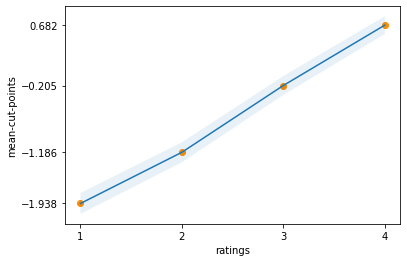

In [54]:
%matplotlib inline
from matplotlib import pyplot as plt
cutpoints = np.vstack([x.cutpoints[0] - x.w0 for x in fm_probit.predictor_.samples])
cp_std = cutpoints.std(axis=0)
cp_mean = cutpoints.mean(axis=0)
plt.plot(cp_mean)
plt.scatter([0,1,2,3],cp_mean,c='#ff8c00')
plt.fill_between(np.arange(4), cp_mean - 2 * cp_std, cp_mean + cp_std * 2, alpha=0.1)
plt.xticks(np.arange(4),np.arange(4)+1)
plt.yticks(cp_mean)
plt.xlabel("ratings")
plt.ylabel("mean-cut-points")
plt.savefig("cutpoints.jpg",dpi=2000)

## Computing slopes of different line segments

In [25]:
cp_mean[1] - cp_mean[0]

0.7522187131548645

In [26]:
cp_mean[2] - cp_mean[1]

0.9810759011425992

In [27]:
cp_mean[3] - cp_mean[2]

0.8867885459575305